In [1]:
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from PIL import ImageEnhance, ImageFilter, ImageOps
from datasets import load_dataset, Dataset, ClassLabel, Features, Image, concatenate_datasets
from tqdm import tqdm
import random

In [2]:
# Load in the Dataset
ds = load_dataset("mwong/faces")
sample_size = 1000
subsampled_train = ds['train'].shuffle(seed=42).select(range(sample_size))
ds_zero_labels = subsampled_train.map(lambda example: {"labels": 0})
ds_zero_labels.save_to_disk("ds_zero_labels")

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

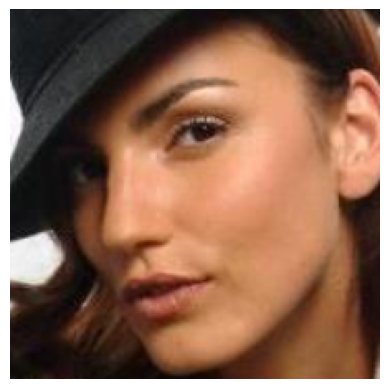

In [3]:
# Load an image
image = ds_zero_labels[0]['image']  # assuming you're using the 'train' split

# Display an image
plt.imshow(image)
plt.axis("off")
plt.show()

In [ ]:
# Load in Positive Class
ds_pos = load_dataset("Jenna")

# Set the label to 1 for all examples
ds_pos = ds_pos["train"].map(lambda example: {"labels": 1})

In [5]:
# Resize all images to 224x224
def resize_image(example):
    # Ensure the image is a PIL Image; if not, convert it.
    if not isinstance(example["image"], PILImage.Image):
        example["image"] = PILImage.fromarray(example["image"])
    # Resize the image to 224x224
    example["image"] = example["image"].resize((512, 512))
    return example

# Apply the resizing function to all examples
ds_pos = ds_pos.map(resize_image)
ds_zero_labels.map(resize_image)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'labels'],
    num_rows: 1000
})

In [6]:
# Define a random augmentation function for face images
def random_augmentation(image):
    # Random horizontal flip with 50% probability
    if random.random() < 0.5:
        image = ImageOps.mirror(image)
    
    # Random brightness adjustment: scale brightness between 0.8 and 1.2
    enhancer = ImageEnhance.Brightness(image)
    brightness_factor = random.uniform(0.8, 1.2)
    image = enhancer.enhance(brightness_factor)
    
    # Random rotation between -15 and 15 degrees
    angle = random.uniform(-15, 15)
    image = image.rotate(angle)
    
    return image

# Initialize lists to store augmented images and labels
augmented_images = []
augmented_labels = []

# For each image in ds_pos, generate 100 augmented samples
for example in ds_pos:
    original_image = example["image"]
    for _ in range(100):  # 100 augmentations for each of the 10 images
        new_image = random_augmentation(original_image)
        augmented_images.append(new_image)
        augmented_labels.append(example["labels"])

# Create a new dataset from the augmented images and labels
ds_augmented = Dataset.from_dict({
    "image": augmented_images,
    "labels": augmented_labels
})

print(f"Augmented dataset size: {len(ds_augmented)}")


Augmented dataset size: 1000


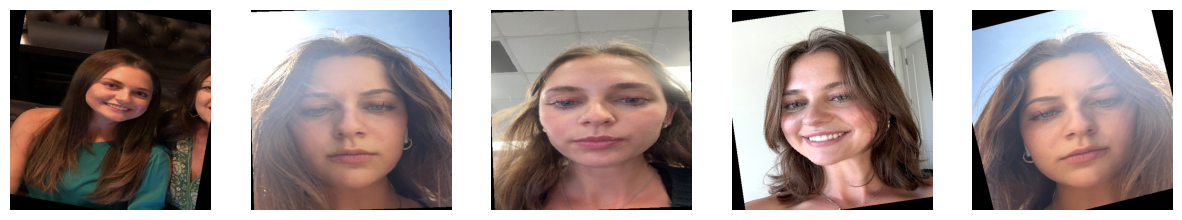

In [7]:
# Verify it worked
ds_augmented = ds_augmented.shuffle(seed=42)

# Randomly select 5 unique indices from the dataset
sample_indices = random.sample(range(len(ds_augmented)), 5)

# Extract the corresponding images
sample_images = [ds_augmented[i]['image'] for i in sample_indices]

# Plot the selected images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, image in zip(axes, sample_images):
    ax.imshow(image)
    ax.axis('off')
plt.show()

In [8]:
# Concatenate Final Dataset 
ds_augmented = ds_augmented.cast(ds_zero_labels.features)
final_dataset = concatenate_datasets([ds_augmented, ds_zero_labels])

# Save Final Dataset
final_dataset.save_to_disk("Final_Dataset")

Casting the dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]